In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

# load the DICOM files from the directory
files = []
directory_path = 'coronal_dicom/'
for fname in glob.glob(directory_path + '/*', recursive=False):
    print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

loading: coronal_dicom\12345.dcm
file count: 1


In [2]:

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))


skipped, no SliceLocation: 1


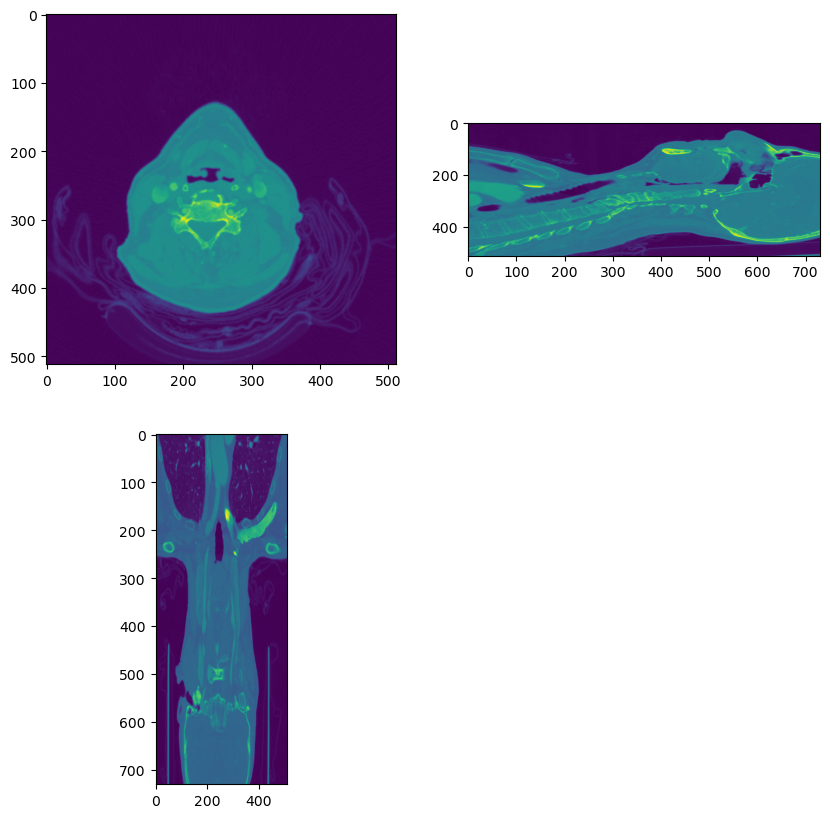

In [3]:

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

plt.figure(figsize=(10,10))
# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

### Split Image to Instances

In [27]:
import os
import pydicom

# Path to the folder containing the DICOM files
folder_path = "D:\\Jupyter Notebooks\\Freelancing\\Monai Dicom\\20 Carotid\\IMAGES"

# Get a list of all DICOM files in the folder
dicom_files = [f for f in os.listdir(folder_path)]

# Create a directory to store the separate series
output_folder = "D:\\Jupyter Notebooks\\Freelancing\\Monai Dicom\\20 Carotid\\Instances"
os.makedirs(output_folder, exist_ok=True)

# Read each DICOM file and save it in a separate series folder
for file_name in dicom_files:
    file_path = os.path.join(folder_path, file_name)
    ds = pydicom.dcmread(file_path)
    
    # Get the series instance UID
    series_uid = ds.SeriesInstanceUID
    
    # Create a folder for the series if it doesn't exist
    series_folder = os.path.join(output_folder, series_uid)
    os.makedirs(series_folder, exist_ok=True)
    
    # Save the DICOM file in the series folder
    output_path = os.path.join(series_folder, file_name)
    ds.save_as(output_path)


In [28]:
import os
import pydicom
import numpy as np
from skimage import exposure, filters

# Path to the folder containing the DICOM files
folder_path = "D:\\Jupyter Notebooks\\Freelancing\\Monai Dicom\\20 Carotid\\Instances\\1.2.276.0.45.1.2.7.3.22002791404224.20230126101851901.36711"

# Get a list of all DICOM files in the folder
dicom_files = [f for f in os.listdir(folder_path)]

# Sort the DICOM files by their instance number
dicom_files.sort(key=lambda x: pydicom.dcmread(os.path.join(folder_path, x)).InstanceNumber)

# Read the DICOM files and apply image processing techniques
processed_images = []
for file_name in dicom_files:
    file_path = os.path.join(folder_path, file_name)
    ds = pydicom.dcmread(file_path)
    
    # Extract the pixel data from the DICOM file
    pixel_array = ds.pixel_array

    # standardize the pixel values
    pixel_array = pixel_array / np.max(pixel_array)

    
    # Append the processed image to the list
    processed_images.append(pixel_array)

# Stack the processed images into a NumPy array
stacked_images = np.stack(processed_images)

# Print the shape of the stacked images array
print("Shape of stacked images array:", stacked_images.shape)


Shape of stacked images array: (120, 512, 512)


In [16]:
img.shape

(3, 928, 1552, 3)

In [29]:
import numpy as np
import torch
from torchvision.transforms import functional as F
from ultralytics import YOLO
import cv2
# Load the YOLOv8 model
model = YOLO('best.pt')  # load a custom model

# Suppose you have a numpy array of images named `images_array`
# Each image in the array should be a 3D numpy array of shape (height, width, channels)
# The entire `images_array` should be a 4D numpy array of shape (number_of_images, height, width, channels)


output_size = (512, 512)  # Size of the output images
output_images = []  # List of output images
# Loop over the images in the numpy array, make predictions, and store them in the `predictions` list
for img in stacked_images:

    # convert PIL Image to float 32
    img = img.astype(np.float32)
    # Convert the image to a PIL Image
    img_pil = F.to_pil_image(img)

    # Resize the image to a size divisible by 32
    img_pil = F.resize(img_pil, (640, 640))

    img_pil = np.stack((img_pil,) * 3, axis=-1)

    # Convert the PIL Image to a torch tensor
    img_tensor = F.to_tensor(img_pil)

    # Add a batch dimension to the tensor
    img_tensor = img_tensor.unsqueeze(0)

    # Make predictions using the YOLOv8 model
    results = model(img_tensor)
    # img = img.astype(np.uint8)
    img = np.expand_dims(img, axis=0)
    img = np.repeat(img, 3, axis=0)
    img = np.transpose(img, (1, 2, 0))
    min_value = np.min(img)
    max_value = np.max(img)
    img =  ((img - min_value) * (255 / (max_value - min_value))).astype(np.uint8)

    for result in results:
        try:
            masks = result.masks
            # Apply each mask to the image
            for mask in masks.data:
                color_mask = np.array([255, 0, 0], dtype=int)  # Red color for the mask
                mask = mask.bool().numpy()  # Convert mask to boolean array
                mask = cv2.resize(mask.astype(np.uint8), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)  # Resize mask to match image dimensions
                img[mask > 0] = color_mask  # Apply red color to the mask
                   # Resize the image to the common size
                img = cv2.resize(img, output_size, interpolation=cv2.INTER_LINEAR)
        except:
            print("no masks found")

    # Append the result to the predictions list
    output_images.append(img)




0: 640x640 (no detections), 481.7ms
Speed: 0.0ms preprocess, 481.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 621.5ms
Speed: 0.0ms preprocess, 621.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 717.7ms
Speed: 0.0ms preprocess, 717.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 693.5ms
Speed: 0.0ms preprocess, 693.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 691.3ms
Speed: 0.0ms preprocess, 691.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 669.1ms
Speed: 0.0ms preprocess, 669.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 676.5ms
Speed: 0.0ms preprocess, 676.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 666.5ms
Speed: 0.0ms preprocess, 666.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 657.3ms
Speed: 0.0ms preprocess, 657.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 681.2ms
Speed: 0.0ms preprocess, 681.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 668.9ms
Speed: 0.0ms preprocess, 668.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 671.6ms
Speed: 0.0ms preprocess, 671.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 722.8ms
Speed: 0.0ms preprocess, 722.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 673.0ms
Speed: 0.0ms preprocess, 673.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 662.8ms
Speed: 0.0ms preprocess, 662.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 658.6ms
Speed: 0.0ms preprocess, 658.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 656.8ms
Speed: 0.0ms preprocess, 656.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 666.0ms
Speed: 0.0ms preprocess, 666.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 675.3ms
Speed: 0.0ms preprocess, 675.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 647.8ms
Speed: 0.0ms preprocess, 647.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 645.7ms
Speed: 0.0ms preprocess, 645.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 655.5ms
Speed: 0.0ms preprocess, 655.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 749.2ms
Speed: 0.0ms preprocess, 749.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 706.5ms
Speed: 0.0ms preprocess, 706.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 705.7ms
Speed: 0.0ms preprocess, 705.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 672.1ms
Speed: 0.0ms preprocess, 672.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 644.7ms
Speed: 0.0ms preprocess, 644.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 674.4ms
Speed: 0.0ms preprocess, 674.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 643.0ms
Speed: 0.0ms preprocess, 643.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 639.1ms
Speed: 0.0ms preprocess, 639.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 625.9ms
Speed: 0.0ms preprocess, 625.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 655.5ms
Speed: 0.0ms preprocess, 655.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 662.4ms
Speed: 0.0ms preprocess, 662.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 643.6ms
Speed: 0.0ms preprocess, 643.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 665.3ms
Speed: 0.0ms preprocess, 665.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 646.7ms
Speed: 0.0ms preprocess, 646.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 667.6ms
Speed: 0.0ms preprocess, 667.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 674.5ms
Speed: 0.0ms preprocess, 674.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 644.8ms
Speed: 0.0ms preprocess, 644.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 730.5ms
Speed: 0.0ms preprocess, 730.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 647.3ms
Speed: 0.0ms preprocess, 647.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 670.1ms
Speed: 0.0ms preprocess, 670.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 645.9ms
Speed: 0.0ms preprocess, 645.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 637.2ms
Speed: 0.0ms preprocess, 637.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 674.1ms
Speed: 0.0ms preprocess, 674.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 643.1ms
Speed: 0.0ms preprocess, 643.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 1 carotid-artery, 670.9ms
Speed: 0.0ms preprocess, 670.9ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 627.4ms
Speed: 0.0ms preprocess, 627.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 648.9ms
Speed: 0.0ms preprocess, 648.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 1 carotid-artery, 650.8ms
Speed: 0.0ms preprocess, 650.8ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 570.5ms
Speed: 0.0ms preprocess, 570.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 721.1ms
Speed: 0.0ms preprocess, 721.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 661.9ms
Speed: 0.0ms preprocess, 661.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 672.0ms
Speed: 0.0ms preprocess, 672.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 699.1ms
Speed: 0.0ms preprocess, 699.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 758.8ms
Speed: 0.0ms preprocess, 758.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 763.8ms
Speed: 0.0ms preprocess, 763.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 741.2ms
Speed: 0.0ms preprocess, 741.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 764.7ms
Speed: 0.0ms preprocess, 764.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 787.2ms
Speed: 0.0ms preprocess, 787.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 854.8ms
Speed: 0.0ms preprocess, 854.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 875.9ms
Speed: 0.0ms preprocess, 875.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 897.7ms
Speed: 0.0ms preprocess, 897.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 1107.2ms
Speed: 0.0ms preprocess, 1107.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 983.5ms
Speed: 0.0ms preprocess, 983.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 1098.9ms
Speed: 0.0ms preprocess, 1098.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 1892.4ms
Speed: 0.0ms preprocess, 1892.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 890.8ms
Speed: 0.0ms preprocess, 890.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 851.9ms
Speed: 0.0ms preprocess, 851.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 941.7ms
Speed: 0.0ms preprocess, 941.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 837.3ms
Speed: 0.0ms preprocess, 837.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 1089.8ms
Speed: 0.0ms preprocess, 1089.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 973.2ms
Speed: 0.0ms preprocess, 973.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 924.6ms
Speed: 0.0ms preprocess, 924.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 1062.4ms
Speed: 0.0ms preprocess, 1062.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 762.3ms
Speed: 0.0ms preprocess, 762.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 779.8ms
Speed: 0.0ms preprocess, 779.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 824.6ms
Speed: 0.0ms preprocess, 824.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 687.6ms
Speed: 0.0ms preprocess, 687.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 682.2ms
Speed: 0.0ms preprocess, 682.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 727.2ms
Speed: 0.0ms preprocess, 727.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 687.3ms
Speed: 0.0ms preprocess, 687.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 681.8ms
Speed: 0.0ms preprocess, 681.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 697.6ms
Speed: 0.0ms preprocess, 697.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 713.9ms
Speed: 0.0ms preprocess, 713.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 788.5ms
Speed: 0.0ms preprocess, 788.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 856.8ms
Speed: 0.0ms preprocess, 856.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 707.6ms
Speed: 0.0ms preprocess, 707.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 727.0ms
Speed: 0.0ms preprocess, 727.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 670.4ms
Speed: 0.0ms preprocess, 670.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 730.2ms
Speed: 0.0ms preprocess, 730.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 704.5ms
Speed: 0.0ms preprocess, 704.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 755.7ms
Speed: 0.0ms preprocess, 755.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 661.7ms
Speed: 0.0ms preprocess, 661.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 687.8ms
Speed: 0.0ms preprocess, 687.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 822.2ms
Speed: 0.0ms preprocess, 822.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 696.5ms
Speed: 0.0ms preprocess, 696.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 688.7ms
Speed: 0.0ms preprocess, 688.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 722.6ms
Speed: 0.0ms preprocess, 722.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 700.2ms
Speed: 0.0ms preprocess, 700.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 764.8ms
Speed: 0.0ms preprocess, 764.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 697.1ms
Speed: 0.0ms preprocess, 697.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 690.3ms
Speed: 0.0ms preprocess, 690.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 662.2ms
Speed: 0.0ms preprocess, 662.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 634.0ms
Speed: 0.0ms preprocess, 634.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 638.7ms
Speed: 0.0ms preprocess, 638.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 642.0ms
Speed: 0.0ms preprocess, 642.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 706.7ms
Speed: 0.0ms preprocess, 706.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 716.5ms
Speed: 0.0ms preprocess, 716.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 660.2ms
Speed: 0.0ms preprocess, 660.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 698.2ms
Speed: 0.0ms preprocess, 698.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 693.6ms
Speed: 0.0ms preprocess, 693.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 714.4ms
Speed: 0.0ms preprocess, 714.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 684.0ms
Speed: 0.0ms preprocess, 684.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 660.4ms
Speed: 0.0ms preprocess, 660.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 689.9ms
Speed: 0.0ms preprocess, 689.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 744.8ms
Speed: 0.0ms preprocess, 744.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 629.7ms
Speed: 0.0ms preprocess, 629.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 670.0ms
Speed: 0.0ms preprocess, 670.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



no masks found


0: 640x640 (no detections), 692.0ms
Speed: 0.0ms preprocess, 692.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


no masks found


In [30]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import generate_uid

# Create a new DICOM file
output_filename = "D:\\Jupyter Notebooks\\Freelancing\\Monai Dicom\\20 Carotid\\Instances\\output1.dcm"
ds = FileDataset(output_filename, {}, file_meta={}, preamble=b"\0" * 128)
output_images = np.array(output_images)
# Set necessary DICOM metadata
ds.Modality = 'CT'
ds.SeriesInstanceUID = generate_uid()
ds.StudyInstanceUID = generate_uid()
ds.FrameOfReferenceUID = generate_uid()
ds.BitsStored = 8
ds.SamplesPerPixel = 1
ds.PhotometricInterpretation = "RGB"  # Use MONOCHROME2 for grayscale images
ds.PixelRepresentation = 0
ds.HighBit = 15
ds.Rows = output_images.shape[1]
ds.Columns = output_images.shape[2]
ds.NumberOfFrames = output_images.shape[0]  # Set the number of frames to the number of slices

# Set pixel data
ds.PixelData = output_images.astype(np.uint8).tobytes()

# Save DICOM file
ds.save_as(output_filename)
